In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mkdir data
!cp "/content/drive/MyDrive/bci_proj/s2_1.zip" "/content/data"
!unzip -n -q "/content/data/s2_1.zip" -x / -d "/content/data"

In [ ]:
!ls data

s2_1.zip			sess01_subj02_EEG_MI.mat
sess01_subj02_EEG_Artifact.mat	sess01_subj02_EEG_SSVEP.mat
sess01_subj02_EEG_ERP.mat


In [ ]:
!pip install mne

     |████████████████████████████████| 6.8MB 11.1MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
from collections import OrderedDict
from matplotlib import pyplot as plt

import mne
from mne.externals.pymatreader import read_mat

In [ ]:
path = "/content/data/sess01_subj02_EEG_SSVEP.mat"
mat_data = read_mat(path)

In [218]:
mat_train = mat_data['EEG_SSVEP_train']

In [ ]:
mat_train.keys()

dict_keys(['smt', 'x', 't', 'fs', 'y_dec', 'y_logic', 'y_class', 'class', 'chan', 'ival', 'time_interval', 'EMG', 'EMG_index', 'pre_rest', 'post_rest', 'rest_interval'])

In [ ]:
times = mat_train['t']

In [ ]:
eeg_data = mat_train['x'].transpose()
eeg_data.shape

(62, 1297480)

In [ ]:
occipital_channels = ['P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'PO10', 'O1', 'Oz', 'O2']

In [ ]:
eeg_channels_indices = []
for channel in occipital_channels:
  eeg_channels_indices.append(mat_train['chan'].index(channel))
eeg_channels_indices

[22, 23, 24, 25, 26, 27, 31, 28, 29, 30]

In [253]:
def leave_occipital_ch(eeg_data):
  eeg_channels_indices = [22, 23, 24, 25, 26, 27, 31, 28, 29, 30]
  
  eeg_data_occipital = np.empty((10, eeg_data.shape[0], eeg_data.shape[3]))
  eeg_data = np.transpose(eeg_data, (1, 0, 2))
  for i, channel in enumerate(eeg_channels_indices, start=0):
    eeg_data_occipital[i] = eeg_data[channel]
  
  return eeg_data_occipital

In [235]:
eeg_data_occipital = np.empty((len(occipital_channels), eeg_data.shape[1]))
eeg_data_occipital.shape


eeg_data_occipital = leave_occipital_ch(eeg_data)

(10, 1297480)

In [252]:
eeg_data_occipital = np.empty((10, ds_trials_new.shape[0], ds_trials_new.shape[2]))


In [ ]:
sfreq = 1000
eeg_channels = occipital_channels
eeg_channel_types = ['eeg'] * len(occipital_channels)

In [ ]:
info = info = mne.create_info(ch_names=occipital_channels, sfreq=sfreq, ch_types=eeg_channel_types)

In [ ]:
raw = mne.io.RawArray(eeg_data_occipital, info)

Creating RawArray with float64 data, n_channels=10, n_times=1297480
    Range : 0 ... 1297479 =      0.000 ...  1297.479 secs
Ready.


In [ ]:
print(raw)
print(raw.info)
type(raw)

<RawArray | 10 x 1297480 (1297.5 s), ~99.0 MB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: P7, P3, Pz, P4, P8, PO9, PO10, O1, Oz, O2
 chs: 10 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 10
 projs: []
 sfreq: 1000.0 Hz
>


mne.io.array.array.RawArray

Effective window size : 2.048 (s)


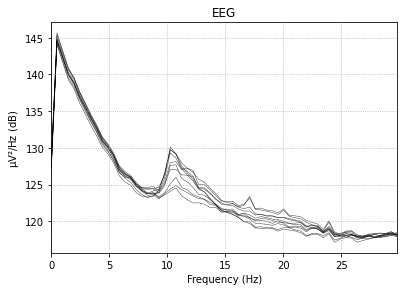

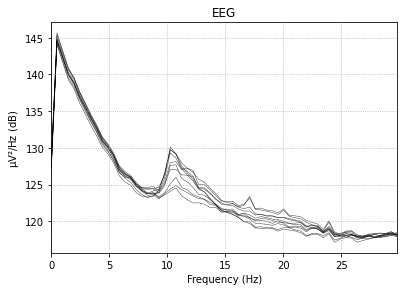

In [ ]:
raw.plot_psd(fmax=30)

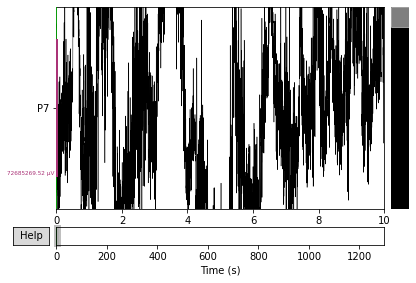

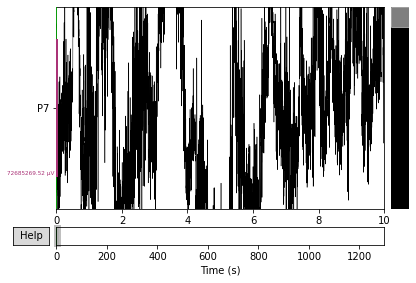

In [ ]:
# It is also possible to auto-compute scalings
scalings = 'auto'  # Could also pass a dictionary with some value == 'auto'
raw.plot(n_channels=1, scalings=scalings, title='Auto-scaled Data from arrays',
         show=True, block=True)

MNE didn't work out, therefore everything was decided to be done manually.

---



In [ ]:
trials = np.empty((10, 100, 4000))
trials.shape

for channel in range(len(eeg_data_occipital)):
  event_id = 0
  for time in times:
    trials[channel][event_id] = eeg_data_occipital[channel][time:(time+4000)]
    event_id += 1
    

In [ ]:
ds_trials = np.empty((10, 100, 400))
print(ds_trials.shape)
print(trials.shape)


for channel in range(len(eeg_data_occipital)):
  for event in range(len(times)):
    for i in range(400):
      ds_trials[channel][event][i] = trials[channel][event][i*10]
ds_trials.shape

(10, 100, 400)
(10, 100, 4000)


(10, 100, 400)

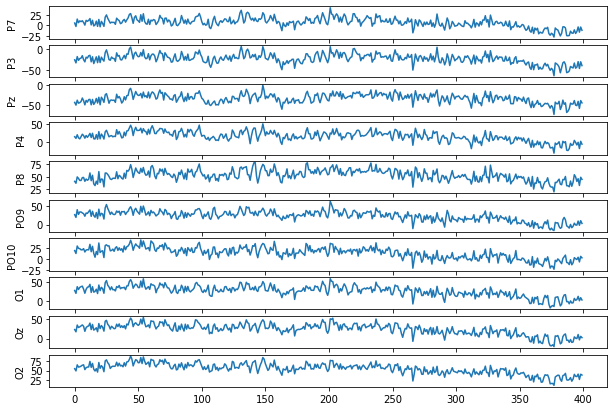

In [ ]:
trials[0][0]
time
#plt.plot(ds_trials[5][2])

trial = 5

plt.rcParams['figure.figsize'] = [10, 7]
fig, axs = plt.subplots(len(ds_trials))
for channel, ax in enumerate(axs, start=0):
  ax.plot(ds_trials[channel][trial])
  ax.set(ylabel=occipital_channels[channel])

In [212]:
X = np.transpose(ds_trials, (1,2,0))

print(X.shape)
pred_freq_score = np.empty(100)
pred_freq_class = np.empty(100, dtype=np.int8)

pred_freq_score.shape

(100, 400, 10)


(100,)

In [273]:
freqs = [12, 8.57, 6.67, 5.45]

In [265]:
from sklearn.cross_decomposition import CCA
import math

def SSVEP_CCA(eeg_data):
  freqs = [12, 8.57, 6.67, 5.45]
  T = np.arange(start=0, stop=4, step=1/100)
  
  pred_freq_score = np.empty(100)
  pred_freq_class = np.empty(100, dtype=np.int8)

  X = np.transpose(eeg_data, (0,2,1))
  
  for x_index, x in enumerate(X, start=0):
    Y = np.empty((4, len(T), 4))
    for i in range(4):
      for t_index, t in enumerate(T, start=0):
        ref = 2*math.pi*freqs[i]*t
        Y[i][t_index] = [math.sin(ref), math.cos(ref), math.sin(ref*2), math.cos(ref*2)]
      
    cca = CCA()
    scores = np.empty(4)
    for y_index, y in enumerate(Y, start=0):
      cca.fit(x, y)
      scores[y_index] = cca.score(x, y)
    
    pred_freq_score[x_index] = scores.max()
    pred_freq_class[x_index] = scores.argmax() + 1
  
  return pred_freq_class

In [266]:
ds_trials_check = np.transpose(ds_trials, (1, 0, 2))
ds_trials_check.shape
classes = SSVEP_CCA(ds_trials_check)

In [268]:
print(classes)
print(mat_train['y_dec'])

[4 4 4 4 4 1 3 3 3 4 4 1 1 1 3 1 2 3 3 1 1 3 4 4 3 2 2 1 2 1 2 1 1 2 2 1 4
 2 2 3 3 2 1 3 3 1 3 3 3 4 3 1 2 2 4 1 1 1 2 4 4 3 1 3 4 1 4 4 3 3 2 3 4 2
 1 3 1 2 2 3 2 4 4 4 1 1 2 2 2 2 1 4 3 2 3 2 4 4 2 4]
[4 4 4 4 4 1 3 3 3 4 4 1 1 1 3 1 2 3 3 1 1 3 4 4 3 2 2 1 2 1 2 1 1 2 2 1 4
 2 2 3 3 2 1 3 3 1 3 3 3 4 3 1 2 2 4 1 1 1 2 4 4 3 1 3 4 1 4 4 3 3 2 3 4 2
 1 3 1 2 2 3 2 4 4 4 1 1 2 2 2 2 1 4 3 2 3 2 4 4 2 4]


In [274]:
correct_count = 0
for i in range(len(classes)):
  if classes[i] == mat_train['y_dec'][i]:
    correct_count +=1 

correct_count

100

In [232]:
X_c, Y_c = cca.transform(x,y)
X_c.shape

(400, 2)